In [1]:
from imaids.models import HybridPlanar as Hybrid
from imaids.blocks import Block
import numpy as np
import matplotlib.pyplot as plt
import radia as rad

def generate_radia_model(solve=False, **kwargs):
    """."""
    nr_periods = 9
    gap = 9.7
    period_length = 29
    br = 1.26

    width = 55
    height = 55
    chamfer = 4

    p_width = 40
    p_height1 = 15.5
    p_height2 = 27.5
    pole_length = 4


    block_shape = [
        [[-width/2, -chamfer],
        [-width/2, -height/2 + chamfer],
        [-width/2 + chamfer, -height/2],
        [width/2 - chamfer, -height/2],
        [width/2, -height/2 + chamfer],
        [width/2, -chamfer],
        [width/2 - chamfer, 0],
        [-width/2 + chamfer, 0]],

        [[-width/2, -chamfer - height/2],
        [-width/2, -height + chamfer],
        [-width/2 + chamfer, -height],
        [width/2 - chamfer, -height],
        [width/2, -height + chamfer],
        [width/2, -chamfer - height/2],
        [width/2 - chamfer, - height/2],
        [-width/2 + chamfer, - height/2]],

    ]

    pole_shape = [

        [[-p_width/2, 0],
         [-p_width/2,  -p_height2 + chamfer],
         [-p_width/2 + chamfer, -p_height2],
         [p_width/2 - chamfer, -p_height2],
         [p_width/2, -p_height2 + chamfer],
         [p_width/2, 0],
         ],


       [[-p_width/2, -chamfer -p_height2],
        [-p_width/2, -p_height1 + chamfer -p_height2],
        [-p_width/2 + chamfer, -p_height1 -p_height2],
        [p_width/2 -chamfer, -p_height1 -p_height2],
        [p_width/2, chamfer - p_height1 -p_height2],
        [p_width/2, -chamfer - p_height2],
        [p_width/2 - chamfer, -p_height2],
        [-p_width/2 + chamfer, -p_height2]],

    ]

    block_subdivision = [[2, 1, 1], [2, 1, 1]]
    pole_subdivision = [[24, 4, 4], [6, 3, 4]]

    start_blocks_length = [3.80, 2.07, 9.10]
    start_blocks_distance = [3.25, 3.25, 0]

    end_blocks_length = [4, 9.10, 2.07, 3.80]
    end_blocks_distance = [0.1, 0, 3.25, 3.25]

    vpu = Hybrid(gap=gap, period_length=period_length,
                 mr=br, nr_periods=nr_periods,
                 longitudinal_distance=0.1, block_shape=block_shape,
                 pole_shape=pole_shape, block_subdivision=block_subdivision,
                 pole_subdivision=pole_subdivision, pole_length=pole_length,
                 start_blocks_length=start_blocks_length,
                 start_blocks_distance=start_blocks_distance,
                 end_blocks_length=end_blocks_length,
                 end_blocks_distance=end_blocks_distance)

    cs_mag = vpu.magnetization_dict['cs']
    cs_mag[0] = [0.0, 0.0, 1.26]
    cs_mag[1] = [0.0, 0.0, 0.0]
    cs_mag[2] = [0.0, 0.0, -1.26]

    cs_mag[-1] = [0.0, 0.0, -1.26]
    cs_mag[-2] = [0.0, 0.0, 0.0]
    cs_mag[-3] = [0.0, 0.0, 1.26]
    cs_mag[-4] = [0.0, 0.0, 0.0]

    mags = np.array(cs_mag)
    mags =  -1*mags
    cs_mag = mags.tolist()

    ci_mag = vpu.magnetization_dict['ci']
    ci_mag[0] = [0.0, 0.0, -1.26]
    ci_mag[1] = [0.0, 0.0, 0.0]
    ci_mag[2] = [0.0, 0.0, 1.26]

    ci_mag[-1] = [0.0, 0.0, 1.26]
    ci_mag[-2] = [0.0, 0.0, 0.0]
    ci_mag[-3] = [0.0, 0.0, -1.26]
    ci_mag[-4] = [0.0, 0.0, 0.0]

    mags = np.array(ci_mag)
    mags =  -1*mags
    ci_mag = mags.tolist()

    magnetization_dict = dict()
    magnetization_dict['cs'] = cs_mag
    magnetization_dict['ci'] = ci_mag

    start_blocks_pole_list = [False, True, False]
    end_blocks_pole_list = [True, False, True, False]
    core_blocks_pole_list = 2*[True, False]*int(
        vpu.cassettes_ref['cs'].nr_core_blocks/2)

    is_pole_list = start_blocks_pole_list + core_blocks_pole_list + end_blocks_pole_list

    vpu.create_radia_object(magnetization_dict=magnetization_dict,
                            is_pole_list=is_pole_list)

    vpu.cassettes['ci'].rotate([0, 0, 0], [0, 0, 1], -np.pi/2)
    vpu.cassettes['cs'].rotate([0, 0, 0], [0, 0, 1], -np.pi/2)

    if solve:
        vpu.solve()

    return vpu


In [2]:
vpu = generate_radia_model(solve=True)


### Field amplitude

0.9039761222474448


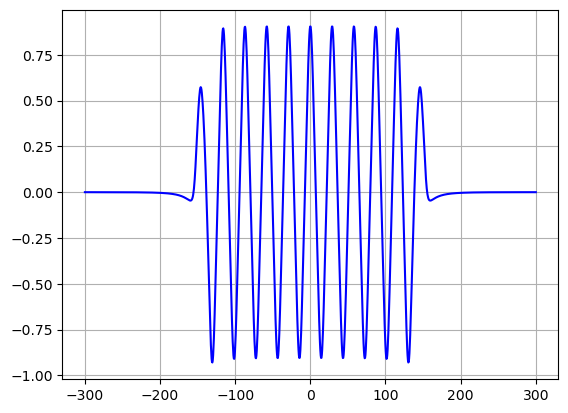

In [9]:
rz = np.linspace(-300, 300, 1200)
field = vpu.get_field(0, 0, z=rz)
bx = field[:, 0]
plt.plot(rz, bx, 'b')
plt.grid()
print(bx.max())


### Field amplitude transverse dependence

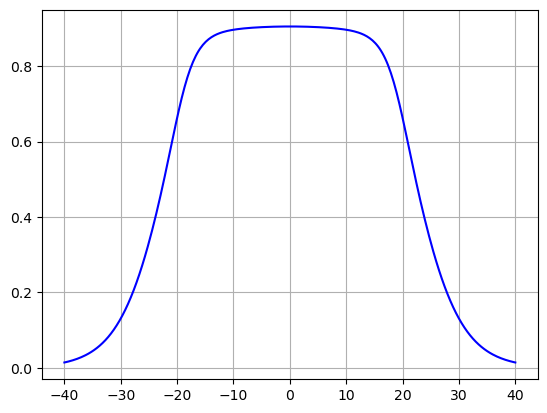

In [10]:
rz = np.linspace(-15, 15, 300)
field = vpu.get_field(0, 0, z=rz)
bx = field[:, 0]
idx = np.argmax(bx)
y = np.linspace(-40, 40, 320)
bx_x = vpu.get_field(0, y, rz[idx])[:, 0]

plt.plot(y, bx_x, 'b')
plt.grid()


### Field roll-off

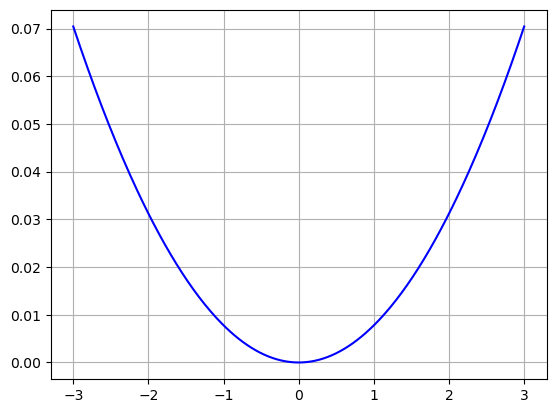

In [11]:
y = np.linspace(-3, 3, 320)
bx_x = vpu.get_field(0, y, rz[idx])[:, 0]
roff = -100*(bx_x - bx[idx])/bx[idx]
plt.plot(y, roff, 'b')
plt.grid()


### Field integrals

In [13]:
rz = np.linspace(-300, 300, 600)
x = np.linspace(-20, 20, 10)
i1 = np.zeros(len(x))

for i, x_ in enumerate(x):
    field = vpu.get_field(x_, 0, z=rz)
    bx = field[:, 0]
    i1[i] = np.trapz(1e4*bx, 1e-3*rz)


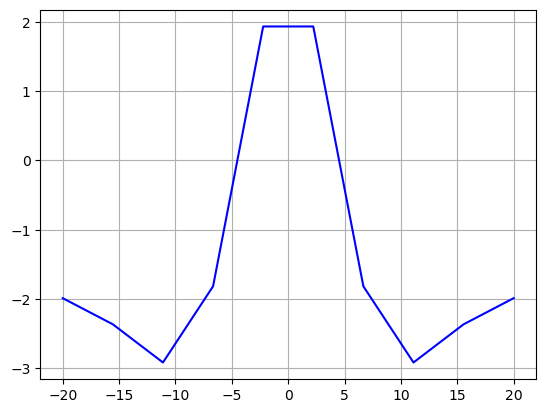

In [20]:
plt.plot(x, i1, 'b')
plt.grid()
